In [11]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from glob import glob
from skimage import io, transform
from google.colab import drive

%matplotlib inline

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
# Load the dataset
df = pd.read_csv('drive/MyDrive/ENGI 4800/author-capstone-20K-limit.csv', sep = '|', header = None)
df.columns = ["pii", "Section_title", "Section_content", "Authors"]

df = df.drop(columns="Section_title")

# Convert the two useful columns into string
df['Authors'] = df['Authors'].str.replace(r'\\', "",regex=True).astype(str)
df['Section_content'] = df['Section_content'].astype(str)


In [3]:
# Consider the full name: Harry James Potter
# Given name + surname: Harry James Potter
def full_name_extraction(s):
  s = s.split(',')
  stack = []
  res = set()
  given_name = None
  surname = None
  for i in s:
    if "given_name_pn" in i:
      given_name = i.split(":")[1].strip('"')
      stack.append(given_name)
    elif "surname_pn" in i:
      if stack:
        given_name = stack.pop()
        surname = i.split(":")[1].strip('"')
        res.add(given_name + ' '+surname)
  return res

# First letter in given name + surname: H. Potter
def initial_surname_extraction(s):
  s = s.split(',')
  stack = []
  res = set()
  initial = None
  surname = None
  for i in s:
    
    if "surname_pn" in i:
        surname = i.split(":")[1].strip('"')
        stack.append(surname)
    
    if "initials_pn" in i:
      initial = i.split(":")[1].replace('{', '').replace('}', '').replace('"', '').replace('[', '').replace(']', '')
      if stack:
        surname = stack.pop()
        res.add(initial + ' '+surname)            # H.J. Potter
        res.add(initial +surname)                 # H.J.Potter
        res.add(initial[0]+'.' +surname)          # H.Potter
        res.add(initial[0]+'. ' +surname)         # H. Potter
  return res

# First letter in given name & surname, both ending with period: H.P.
# Sometimes the last period is emitted: H.P
# Sometimes there is a space between the initials H. P or H. P.
# Sometimes the middle name's initial is also included: H.J.P. or H.J.P
# It should not overlap with initial+surname
def initials_extraction(flag, s):
  s = s.split(',')
  stack = []
  res = set()
  initial = None
  surname = None
  if not flag:
    for i in s:
    
      if "surname_pn" in i:
          surname = i.split(":")[1].strip('"')[0]
          stack.append(surname)
    
      if "initials_pn" in i:
        initial = i.split(":")[1].replace('{', '').replace('}', '').replace('"', '').replace('[', '').replace(']', '')
        if stack:
          surname = stack.pop()
          res.add(initial +surname+'.')                            # H.J.P.
          res.add(initial +' '+surname+'.')                        # H.J. P.
          res.add(initial +surname)                                # H.J.P
          res.add(initial +' '+surname)                            # H.J. P
          res.add(initial[0]+'.'+surname)                          # H.P
          res.add(initial[0]+'.'+surname+'.')                      # H.P.
          res.add(initial[0]+'. '+surname)                         # H. P
          res.add(initial[0]+'. '+surname+'.')                     # H. P.
          res.add(initial.replace(".", ". ")+'. '+surname+'.')     # H. J. P.
          res.add(initial.replace(".", ". ")+'. '+surname)         # H. J. P
  return res


# First letter in given name & surname, no period: HP or HJP
def abbreviation_extraction(s):
  s = s.split(',')
  stack = []
  res = set()
  initial = None
  surname = None
  for i in s:
    
    if "surname_pn" in i:
        surname = i.split(":")[1].strip('"')[0]
        stack.append(surname)
    
    if "initials_pn" in i:
      initial = i.split(":")[1].replace('{', '').replace('}', '').replace('"', '').replace('[', '').replace(']', '')
      if stack:
        surname = stack.pop()
        res.add(initial[0]+surname)                  # HP
        res.add(initial.replace(".",'')+surname)     # HJP

  return res

# Surname only: Potter
# This category does not overlap with full name and initial + surname
def surname_extraction(flag1, flag2, flag3, s):
  s = s.split(',')

  res = set()
  if not flag1 and not flag2 and not flag3:
    for i in s:
      if "surname_pn" in i:
        surname = i.split(":")[1].strip('"')       # Potter
        res.add(surname)
  return res



# The surname's initial + period + the given name's initial: P.H. or P.H
# sometime includes a space: P. H. or P. H
def reversed_initials_extraction(s):
  s = s.split(',')
  stack = []
  res = set()
  initial = None
  surname = None
  for i in s:
    
    if "surname_pn" in i:
        surname = i.split(":")[1].strip('"')[0]
        stack.append(surname)
    
    if "initials_pn" in i:
      initial = i.split(":")[1].replace('{', '').replace('}', '').replace('"', '').replace('[', '').replace(']', '')
      if stack:
        surname = stack.pop()
        res.add(surname+'.'+initial)          # P.H.
        res.add(surname+'.'+initial[0])       # P.H
        res.add(surname+'. '+initial)         # P. H.
        res.add(surname+'. '+initial[0])      # P. H
  return res

# Reversed Abbreviation: PH
def reversed_abbreviation_extraction(s):
  s = s.split(',')
  stack = []
  res = set()
  initial = None
  surname = None
  for i in s:
    
    if "surname_pn" in i:
        surname = i.split(":")[1].strip('"')[0]
        stack.append(surname)
    
    if "initials_pn" in i:
      initial = i.split(":")[1].replace('{', '').replace('}', '').replace('"', '').replace('[', '').replace(']', '')
      if stack:
        surname = stack.pop()
        res.add(surname+initial[0])        # PH
  return res


# Given name only: Harry
# This category does not overlap with full name
def given_name_extraction(flag, s):
  s = s.split(',')

  res = set()
  if not flag:
    for i in s:
      if "given_name_pn" in i:
        given_name = i.split(":")[1].strip('"')
        res.add(given_name)               # Harry
  return res


def name_exist(content, names):
  if names:
    for name in names:
      if name in content:
        return True
  return False

In [4]:
df['Full_Names'] = df['Authors'].apply(full_name_extraction)
df['Full_Names_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Full_Names), axis=1)

df['Initial_Surname'] = df['Authors'].apply(initial_surname_extraction)
df['Initial_Surname_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Initial_Surname), axis=1)

df['Initials'] = df.apply(lambda x: initials_extraction(x.Initial_Surname_Flag, x.Authors), axis=1)
df['Initials_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Initials), axis=1)

df['Abbreviation'] = df['Authors'].apply(abbreviation_extraction)
df['Abbreviation_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Abbreviation), axis=1)

df['Surname'] = df.apply(lambda x: surname_extraction(x.Full_Names_Flag, x.Initial_Surname_Flag, x.Initials_Flag, x.Authors), axis=1)
df['Surname_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Surname), axis=1)

df['Given_Name'] = df.apply(lambda x: given_name_extraction(x.Full_Names_Flag, x.Authors), axis=1)
df['Given_Name_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Given_Name), axis=1)

df['Reversed_Initials'] = df['Authors'].apply(reversed_initials_extraction)
df['Reversed_Initials_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Reversed_Initials), axis=1)

df['Reversed_Abbreviation'] = df['Authors'].apply(reversed_abbreviation_extraction)
df['Reversed_Abbreviation_Flag'] = df.apply(lambda x: name_exist(x.Section_content, x.Reversed_Abbreviation), axis=1)

In [5]:
print(sum(df['Full_Names_Flag']))
print(sum(df['Initial_Surname_Flag']))
print(sum(df['Initials_Flag']))
print(sum(df['Abbreviation_Flag']))
print(sum(df['Surname_Flag']))
print(sum(df['Given_Name_Flag']))
print(sum(df['Reversed_Initials_Flag']))
print(sum(df['Reversed_Abbreviation_Flag']))

4774
1278
5776
4340
1159
469
3264
1945


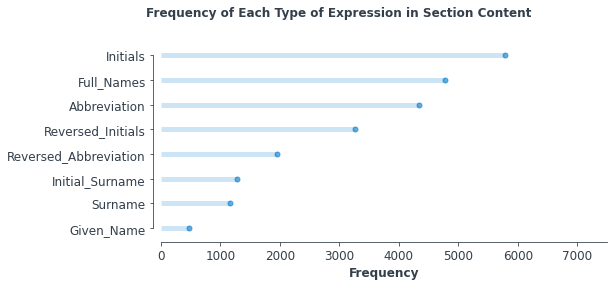

In [6]:
# set font
# plt.rcParams['font.family'] = 'sans-serif'
# plt.rcParams['font.sans-serif'] = 'Helvetica'

# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'

flag_ls = ['Full_Names', 'Initial_Surname', 'Initials', 'Abbreviation', 
           'Surname', 'Given_Name','Reversed_Initials', 'Reversed_Abbreviation']

frequency = pd.Series([sum(df[flag+'_Flag']) for flag in flag_ls], index = flag_ls)

frequency = pd.DataFrame({'Frequency' : frequency})
frequency = frequency.sort_values(by='Frequency')


# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(frequency.index)+1))

fig, ax = plt.subplots(figsize=(8,3.5))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=frequency['Frequency'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(frequency['Frequency'], my_range, "o", markersize=5, color='#007ACC', alpha=0.6)

# set labels
ax.set_xlabel('Frequency', fontsize=12, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=12)
plt.yticks(my_range, frequency.index)

# add an horizonal label for the y axis 
fig.text(0.1, 1, 'Frequency of Each Type of Expression in Section Content', fontsize=12, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
ax.set_xlim(0,7500)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))


In [7]:
column_names = [flag+'_Flag' for flag in flag_ls]

df['Multiple_Combinations'] = df[column_names].sum(axis=1)

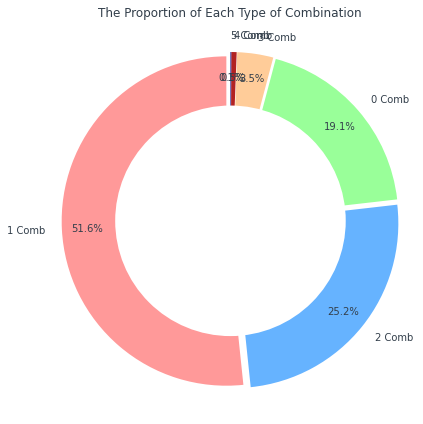

In [10]:
# Pie chart
labels = [str(i) + ' Comb' for i in list(df['Multiple_Combinations'].value_counts().index)]
values = list(df['Multiple_Combinations'].value_counts().values)
#colors
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99','firebrick', 'navy']
 
fig1, ax1 = plt.subplots(figsize = (6,6))
#explsion
explode = (0.025,0.025,0.025,0.025,0.025,0.025)
 
ax1.pie(values, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
plt.title("The Proportion of Each Type of Combination")
plt.tight_layout()
plt.show()

In [13]:
df['Section_content'][3]

'The authors confirm contribution to the paper as follows: study conception and design: Zubayer Islam, Mohamed Abdel-Aty, Qing Cai; data collection: Qing Cai, Jinghui Yuan, Zubayer Islam; analysis and interpretation of results: Zubayer Islam, Mohamed Abdel-Aty; draft manuscript preparation: Zubayer Islam, Mohamed Abdel-Aty. All authors reviewed the results and approved the final version of the manuscript.'

In [14]:
df['Authors'][3]

'[{Authorseq":1,"auid":57221288000,"given_name_pn":"Zubayer","surname_pn":"Islam","initials_pn":"Z."},{"Authorseq":2,"auid":7006423551,"given_name_pn":"Mohamed","surname_pn":"Abdel-Aty","initials_pn":"M."},{"Authorseq":3,"auid":56323815300,"given_name_pn":"Qing","surname_pn":"Cai","initials_pn":"Q."},{"Authorseq":4,"auid":57139150400,"given_name_pn":"Jinghui","surname_pn":"Yuan","initials_pn":"J."}]"'